![logo](./img/LogoLine_horizon_C3S.png)

<br>

# Seasonal Forecast Anomalies

### About

This notebook provides a practical introduction to calculating seasonal forecast anomalies with data from the Copernicus Climate Change Service (C3S). C3S seasonal forecast products are based on data from several state-of-the-art seasonal prediction systems. In this tutorial we shall focus on the [ECMWF SEAS5 model](https://confluence.ecmwf.int/display/CKB/Description+of+SEAS5+C3S+contribution), which is one of the forecasting systems available through C3S.

The tutorial will demonstrate how to access real-time forecast data of total precipitation, with a forecast start date in May 2021 and 6 monthly lead times (up to October 2021). Hindcast data for the same start date and lead-time months in the reference period 1993 to 2016 will also be downloaded. The tutorial will then show how to extract a subset area over South Asia for both the forecast and hindcast data. The climate mean for the reference period will be computed and this reference mean will be subtracted from the real-time forecast data to derive monthly anomalies. These will be visualised as both spatial maps and time series. Finally, 3-monthly anomalies will be calculated and visualised in an interactive plot, as a demonstration of how to reproduce similar [charts available through C3S](https://climate.copernicus.eu/charts/c3s_seasonal/).


The notebook has the following outline:
* 1 - Download data from the CDS
* 2 - Hindcast data processing: calculate the reference climate mean
* 3 - Real-time forecasts: calculate seasonal forecast anomalies
* 4 - Visualize seasonal forecast monthly anomalies for a geographical subregion
  * 4.1 - Spatial maps
  * 4.2 - Time series of regional averages
* 5 - Reproduce C3S graphical products: compute 3-month anomalies

<br>

<div class="alert alert-block alert-success">
<b>NOTE</b>: <br>
    <a href="https://cds-beta.climate.copernicus.eu/datasets/seasonal-postprocessed-single-levels?tab=overview">Precomputed anomalies are also available through the CDS</a>. Note these may be slightly different due to minor differences in the way they are computed (e.g. months of constant length, 30 days)  and also due to GRIB packing discretisation. <a href="https://confluence.ecmwf.int/display/UDOC/Why+are+there+sometimes+small+negative+precipitation+accumulations+-+ecCodes+GRIB+FAQ">See here for more detials.</a></div>

Please see here the full documentation of the [C3S Seasonal Forecast Datasets](https://confluence.ecmwf.int/display/CKB/C3S+Seasonal+Forecasts%3A+datasets+documentation). This notebook introduces you to the [seasonal forecast monthly statistics](https://cds-beta.climate.copernicus.eu/datasets/seasonal-monthly-single-levels?tab=overview) datasets on single levels (as opposed to multiple levels in the atmosphere).

<style>
td, th {
   border: 1px solid white;
   border-collapse: collapse;
}
</style>
<table align="left">
  <tr>
    <th>Run the tutorial via free cloud platforms: </th>
    <th><a href="https://mybinder.org/v2/gh/ecmwf-projects/copernicus-training-c3s/main?labpath=sf-anomalies.ipynb">
        <img src = "https://mybinder.org/badge.svg" alt = "Binder"></th>
    <th><a href="https://kaggle.com/kernels/welcome?src=https://github.com/ecmwf-projects/copernicus-training-c3s/blob/main/sf-anomalies.ipynb">
        <img src = "https://kaggle.com/static/images/open-in-kaggle.svg" alt = "Kaggle"></th>
    <th><a href="https://colab.research.google.com/github/ecmwf-projects/copernicus-training-c3s/blob/main/sf-anomalies.ipynb">
        <img src = "https://colab.research.google.com/assets/colab-badge.svg" alt = "Colab"></th>
  </tr>
</table>

<hr>

### Load packages

In [8]:
# Miscellaneous operating system interfaces
import os

# CDS API
import cdsapi

# To map GRIB files to NetCDF Common Data Model
import cfgrib

# Libraries for working with multi-dimensional arrays
import numpy as np
import xarray as xr
import pandas as pd

# Libraries for plotting and geospatial data visualisation
import matplotlib.path as mpath
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

# To work with data labels in dictionary format
from collections import OrderedDict

# Date and time related libraries
from dateutil.relativedelta import relativedelta
from calendar import monthrange
import datetime

# Interactive HTML widgets
import ipywidgets as widgets

# Disable warnings for data download via API
import urllib3 
urllib3.disable_warnings()

<hr>

## 1. Request data from the CDS programmatically with the CDS API

The first step is to request data from the Climate Data Store programmatically with the help of the CDS API. Let us make use of the option to manually set the CDS API credentials. First, you have to define two variables: `URL` and `KEY` which build together your CDS API key. Below, you have to replace the `#########` with your personal CDS key. Please find [here](https://cds-beta.climate.copernicus.eu/how-to-api) your personal CDS key.

In [10]:
URL = 'https://cds-beta.climate.copernicus.eu/api'
KEY = '328ae3b8-36e2-4c27-9892-c7a55f386cdf'

Here we specify a data directory in which we will download our data and all output files that we will generate:

In [13]:
DATADIR = '/home/mohamed/EHTPIII/MODELISATION/DATA/'

The next step is then to request the seasonal forecast monthly statistics data on single levels with the help of the CDS API. Below, we download two separate files of total precipitation for six monthly lead times (start date in May):
* **Retrospective forecasts (Hindcasts) for 1993 to 2016**
* **Forecasts for 2021**

Seasonal forecast data are disseminated in the GRIB data format. Let us store the data in the main working directory with the names: 
* `ecmwf_seas5_1993-2016_05_hindcast_monthly_tp.grib` and 
* `ecmwf_seas5_2021_05_forecast_monthly_tp.grib`.

Running the code block below will download the data from the CDS as specified by the following API keywords:

> **Format**: `Grib` <br>
> **Originating centre**: `ECMWF` <br>
> **System**: `5` *this refers to SEAS5* <br>
> **Variable**: `Total precipitation` <br>
> **Product type**: `Monthly mean` *all ensemble members will be retrieved* <br>
> **Year**: `1993 to 2016` *for the hindcast* `2021` *for the forecast* <br>
> **Month**: `05` *May* <br>
> **Leadtime month**: `1 to 6` *May to October*

If you have not already done so, you will need to accept the **terms & conditions** of the data before you can download it. These can be viewed and accepted in the [CDS download page](https://cds-beta.climate.copernicus.eu/datasets/seasonal-monthly-single-levels?tab=download) by scrolling to the end of the download form.

<div class="alert alert-block alert-success">
<b>NOTE</b>: <br>
    The API request below can be generated automatically from the <a href="https://cds-beta.climate.copernicus.eu/datasets/seasonal-monthly-single-levels?tab=download">CDS download page</a>. At the end of the download form there is a <code>Show API request</code> icon, which allows a copy-paste of the code below.</div>

In [15]:
c = cdsapi.Client(url=URL, key=KEY)

# Hindcast data request
c.retrieve(
    'seasonal-monthly-single-levels',
    {
        'format': 'grib',
        'originating_centre': 'ecmwf',
        'system': '5',
        'variable': 'total_precipitation',
        'product_type': 'monthly_mean',
        'year': [
            '1993', '1994', '1995',
            '1996', '1997', '1998',
            '1999', '2000', '2001',
            '2002', '2003', '2004',
            '2005', '2006', '2007',
            '2008', '2009', '2010',
            '2011', '2012', '2013',
            '2014', '2015', '2016',
        ],
        'month': '05',
        'leadtime_month': [
            '1', '2', '3',
            '4', '5', '6',
        ],
    },
    f'{DATADIR}/ecmwf_seas5_1993-2016_05_hindcast_monthly_tp.grib')

# Forecast data request
c.retrieve(
    'seasonal-monthly-single-levels',
    {
        'format': 'grib',
        'originating_centre': 'ecmwf',
        'system': '5',
        'variable': 'total_precipitation',
        'product_type': 'monthly_mean',
        'year': '2021',
        'month': '05',
        'leadtime_month': [
            '1', '2', '3',
            '4', '5', '6',
        ],
    },
    f'{DATADIR}/ecmwf_seas5_2021_05_forecast_monthly_tp.grib')

2024-10-10 11:39:25,927 INFO [2024-09-28T00:00:00] **Welcome to the New Climate Data Store (CDS)!** This new system is in its early days of full operations and still undergoing enhancements and fine tuning. Some disruptions are to be expected. Your 
[feedback](https://jira.ecmwf.int/plugins/servlet/desk/portal/1/create/202) is key to improve the user experience on the new CDS for the benefit of everyone. Thank you.
2024-10-10 11:39:25,929 WARNING [2024-09-26T00:00:00] Should you have not yet migrated from the old CDS system to the new CDS, please check our [informative page](https://confluence.ecmwf.int/x/uINmFw) for guidance.
2024-10-10 11:39:25,931 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2024-10-10 11:39:25,933 INFO [2024-09-16T00:00:00] Remember that you need to have an ECMWF account to use the new CDS. **Your old CDS credentials will not work in new CDS!**
2024-10-10 11:39:25,934 WARNING [2024-06-16T

c061d3530c83a37812f6084c51d236de.grib:   0%|          | 0.00/448M [00:00<?, ?B/s]

2024-10-10 11:44:23,619 INFO Request ID is 80b56b52-8891-46d0-bdee-4459b04029e5
2024-10-10 11:44:23,688 INFO status has been updated to accepted
2024-10-10 11:44:31,506 INFO status has been updated to running
2024-10-10 11:45:38,821 INFO status has been updated to successful


88afcedc348f06b55d6e5bd07c0e5a8f.grib:   0%|          | 0.00/38.1M [00:00<?, ?B/s]

'/home/mohamed/EHTPIII/MODELISATION/DATA//ecmwf_seas5_2021_05_forecast_monthly_tp.grib'

<br>

## 2. Calculate seasonal hindcast climate mean

Seasonal forecasts are affected by systematic errors (biases) which are dependent on the leadtime, the time of year, the variable and the location. Hindcast data can help us to understand and account for these biases. We will calculate the hindcast climate mean for each lead time month, averaged over the years 1993 to 2016. In the next section we will then calculate the anomalies, i.e. the deviation of the 2021 forecast for each lead time month with respect to the hindcast mean. Anomalies are thus calculated "in the model space" where the model climate calculated from the hindcasts is taken as the reference.

#### Read the downloaded data

We will use the Python library [xarray](http://xarray.pydata.org/en/stable/) and its function `open_dataset` to read the GRIB file of the hindcast data, specifying the keyword argument `engine` and `'cfgrib'`. [cfgrib](https://github.com/ecmwf/cfgrib) is a Python interface to map GRIB files to the NetCDF Common Data Model using [ecCodes](https://github.com/ecmwf/eccodes).

The result is a `xarray.Dataset` object with five dimensions:

> **Number**: Ensemble members (25) <br>
> **Time**: Forecast start date for each year (1st of May) <br>
> **Step**: Lead time (nanoseconds in each leadtime month) <br>
> **Latitude**: Latitudes in 1 deg resolution<br>
> **Longitude**: Longitudes in 1 deg resolution and in 0-360 grid<br>

In [17]:
ds = xr.open_dataset(f'{DATADIR}/ecmwf_seas5_1993-2016_05_hindcast_monthly_tp.grib', engine='cfgrib')
ds

/home/mohamed/anaconda3/lib/python3.12/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'gini' loading failed:
No module named 'pooch'
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


<xarray.Dataset>
Dimensions:     (number: 25, time: 24, step: 6, latitude: 181, longitude: 360)
Coordinates:
  * number      (number) int64 0 1 2 3 4 5 6 7 8 ... 16 17 18 19 20 21 22 23 24
  * time        (time) datetime64[ns] 1993-05-01 1994-05-01 ... 2016-05-01
  * step        (step) timedelta64[ns] 31 days 61 days ... 153 days 184 days
    surface     float64 ...
  * latitude    (latitude) float64 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * longitude   (longitude) float64 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
    valid_time  (time, step) datetime64[ns] ...
Data variables:
    tprate      (number, time, step, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-10T11:50 GRIB to CDM+CF via cfgrib-0.9.1...

#### Change representation of forecast lead time

Notice that xarray attempts to extract the time dimensions from the metadata in the GRIB file. By default, it tries to arrange the shape of the data array using “time” (the start time) and “step” (the lead-time in nanoseconds). This comes with two potential issues:
- Due to some limitations in the GRIB edition 1 encoding of long forecasts, monthly aggregations such as these do not perfectly encode the start and end of the aggregation period (calendar months), and instead they use “step”, which points to the end of the aggregating interval. This might be misleading.  
- Due to the different lengths of February in leap and non/leap years, we might have different values of “step” for the same “leadtime_month” index when we put together different start years, as we do here.

A more useful representation of the data is to replace the dimension “step” with “forecastMonth”, which is part of the GRIB metadata and provides the same integer indices used in the CDS API syntax for “leadtime_month”, with the value 1 corresponding to the first complete calendar month after the forecast start date. For instance for a forecast with start date on the 1st May, `forecastMonth=1` is May, and for a forecast with start date on 17th April, `forecastMonth=1` would also be May. This is more coherent and avoids the ambiguity described above.

We will create this custom data structure through use of the  keyword argument `backend_kwargs` with the `time_dims` option, specifying the two time dimensions: `forecastMonth` and `time` (or `indexing_time`, see note below). The new dataset will then have `forecastMonth` instead of `step`, with values from 1 to 6 (for each lead time month). In this conversion we will lose some information about `valid_time`, which we will need to calculate later.

<div class="alert alert-block alert-success">
<b>NOTE</b>: <br>
    The second of the time dimensions is valid for systems with burst start dates (such as in our example), but for lagged systems, <i>time</i> should be replaced with <i>indexing_time</i>. Please see <a href="https://confluence.ecmwf.int/display/CKB/Seasonal+forecasts+and+the+Copernicus+Climate+Change+Service#heading-Burstvslaggedmode">here</a> for more details on the difference between burst and lagged systems.</div>

In [22]:
ds_hindcast = xr.open_dataset(f'{DATADIR}/ecmwf_seas5_1993-2016_05_hindcast_monthly_tp.grib', engine='cfgrib', backend_kwargs=dict(time_dims=('forecastMonth', 'time')))
ds_hindcast

<xarray.Dataset>
Dimensions:        (number: 25, forecastMonth: 6, time: 24, latitude: 181,
                    longitude: 360)
Coordinates:
  * number         (number) int64 0 1 2 3 4 5 6 7 8 ... 17 18 19 20 21 22 23 24
  * forecastMonth  (forecastMonth) int64 1 2 3 4 5 6
  * time           (time) datetime64[ns] 1993-05-01 1994-05-01 ... 2016-05-01
    surface        float64 ...
  * latitude       (latitude) float64 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * longitude      (longitude) float64 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
Data variables:
    tprate         (number, forecastMonth, time, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-10T11:57 GRIB to CDM+CF via cfgrib-0.9.1...

#### Extract data array from dataset

The `xarray.Dataset` object into which we have read the data from the downloaded GRIB files may contain arrays of multiple variables (even if we have only one: total precipitation). Another xarray data structure, `xarray.DataArray`, facilitates operations on single variables. We will use this to further process our data. You can select the relevant DataArray from a Dataset by specifying the name of the variable (in our case `tprate`) in square brackets `[]`. 

In [25]:
tprate_hindcast = ds_hindcast['tprate']
tprate_hindcast

<xarray.DataArray 'tprate' (number: 25, forecastMonth: 6, time: 24,
                            latitude: 181, longitude: 360)>
[234576000 values with dtype=float32]
Coordinates:
  * number         (number) int64 0 1 2 3 4 5 6 7 8 ... 17 18 19 20 21 22 23 24
  * forecastMonth  (forecastMonth) int64 1 2 3 4 5 6
  * time           (time) datetime64[ns] 1993-05-01 1994-05-01 ... 2016-05-01
    surface        float64 ...
  * latitude       (latitude) float64 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * longitude      (longitude) float64 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
Attributes: (12/31)
    GRIB_paramId:                             172228
    GRIB_dataType:                            fcmean
    GRIB_numberOfPoints:                      65160
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_shortName:                           tprate
    GRIB_totalNumber:                         0
    GRIB_units:                               m s**-1
    long_name:                                Mean total precipitation rate
    units:                                    m s**-1
    standard_name:                            unknown

A DataArray provides additional attributes of the variable. For example, you see that the precipitation is expressed as a rate with the unit m/s. Some variables (like precipitation, radiation or heat fluxes) are encoded in GRIB as accumulations from the beginning of the forecast, and their monthly aggregations are therefore expressed as rates. Later in this tutorial we shall convert this to total accumulation.

#### Average over ensemble members and years to create hindcast climatology

We can now create the hindcast climatology by averaging over the 25 ensemble members and the 24 years. We do this for each forecast lead time and for each geographical grid point. We use the function `mean()` to average over one or more dimensions, which in this case are `number` (25 ensemble members) and `time` (years from 1993 to 2016). The result is an `xarray.DataArray` with three dimensions: `forecastMonth`, `latitude` and `longitude`.

In [27]:
tprate_hindcast_mean = tprate_hindcast.mean(['number', 'time'])
tprate_hindcast_mean

<xarray.DataArray 'tprate' (forecastMonth: 6, latitude: 181, longitude: 360)>
array([[[7.27389615e-09, 7.27389615e-09, 7.27389615e-09, ...,
         7.27389615e-09, 7.27389615e-09, 7.27389615e-09],
        [7.05738801e-09, 7.06172898e-09, 7.06613124e-09, ...,
         7.02487624e-09, 7.03560854e-09, 7.04628000e-09],
        [6.97020974e-09, 6.98274860e-09, 6.99498459e-09, ...,
         6.92369229e-09, 6.93917768e-09, 6.95467550e-09],
        ...,
        [1.82400983e-09, 1.81782522e-09, 1.81168924e-09, ...,
         1.84227245e-09, 1.83622129e-09, 1.83006099e-09],
        [2.29911779e-09, 2.29435204e-09, 2.28950126e-09, ...,
         2.31278441e-09, 2.30798225e-09, 2.30361663e-09],
        [2.70048384e-09, 2.70048384e-09, 2.70048384e-09, ...,
         2.70048384e-09, 2.70048384e-09, 2.70048384e-09]],

       [[1.09858567e-08, 1.09858567e-08, 1.09858567e-08, ...,
         1.09858567e-08, 1.09858567e-08, 1.09858567e-08],
        [1.03791900e-08, 1.03840039e-08, 1.03888187e-08, ...,
         1.03511049e-08, 1.03604423e-08, 1.03695976e-08],
        [1.00812407e-08, 1.01029229e-08, 1.01244479e-08, ...,
         1.00160129e-08, 1.00379500e-08, 1.00590860e-08],
...
        [1.44419199e-09, 1.43627332e-09, 1.43029510e-09, ...,
         1.46575330e-09, 1.45882895e-09, 1.45046153e-09],
        [1.81951088e-09, 1.81518167e-09, 1.80927595e-09, ...,
         1.83453575e-09, 1.82824200e-09, 1.82482229e-09],
        [2.13508144e-09, 2.13508144e-09, 2.13508144e-09, ...,
         2.13508144e-09, 2.13508144e-09, 2.13508144e-09]],

       [[9.10134101e-09, 9.10134101e-09, 9.10134101e-09, ...,
         9.10134101e-09, 9.10134101e-09, 9.10134101e-09],
        [9.29670030e-09, 9.30316357e-09, 9.30803878e-09, ...,
         9.26988797e-09, 9.27865607e-09, 9.28798105e-09],
        [9.43461576e-09, 9.45326661e-09, 9.47201428e-09, ...,
         9.36220790e-09, 9.38479960e-09, 9.41219369e-09],
        ...,
        [1.38621803e-09, 1.38139167e-09, 1.37470990e-09, ...,
         1.40482015e-09, 1.39895096e-09, 1.39447620e-09],
        [1.74624459e-09, 1.74307957e-09, 1.74176984e-09, ...,
         1.75345993e-09, 1.75191983e-09, 1.74754211e-09],
        [2.07671835e-09, 2.07671835e-09, 2.07671835e-09, ...,
         2.07671835e-09, 2.07671835e-09, 2.07671835e-09]]], dtype=float32)
Coordinates:
  * forecastMonth  (forecastMonth) int64 1 2 3 4 5 6
    surface        float64 ...
  * latitude       (latitude) float64 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * longitude      (longitude) float64 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0

<br>

## 3. Load monthly seasonal forecast data for 2021 and calculate seasonal forecast anomalies

The next step is to load the real-time seasonal forecast data for 6 lead time months in 2021, beginning in May. We will then subtract the hindcast climatology from this to derive the anomalies. 

#### Load seasonal forecast data for 2021 and change representation of forecast lead time

Before we can subtract the hindcast anomaly from the 2021 forecast, we need first to ensure the two datasets have the same structure. We thus need to apply the same processing on the forecast data as we did with the hindcast to use `forecastMonth` as a coordinate of the array instead of `step`.

In [31]:
seas5_forecast = xr.open_dataset(f'{DATADIR}/ecmwf_seas5_2021_05_forecast_monthly_tp.grib', engine='cfgrib', 
                                 backend_kwargs=dict(time_dims=('forecastMonth', 'time')))
seas5_forecast

<xarray.Dataset>
Dimensions:        (number: 51, forecastMonth: 6, latitude: 181, longitude: 360)
Coordinates:
  * number         (number) int64 0 1 2 3 4 5 6 7 8 ... 43 44 45 46 47 48 49 50
  * forecastMonth  (forecastMonth) int64 1 2 3 4 5 6
    time           datetime64[ns] ...
    surface        float64 ...
  * latitude       (latitude) float64 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * longitude      (longitude) float64 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
Data variables:
    tprate         (number, forecastMonth, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-10T12:00 GRIB to CDM+CF via cfgrib-0.9.1...

Once the `xarray.Dataset` is loaded, you see that it has 4 dimensions:
> **Number**: 51 ensemble members <br>
> **ForecastMonth**: 6 leadtime months <br>
> **Latitude**: latitude values <br>
> **Longitude**: longitude values <br>

Compared to the hindcast data, we have only a single start date (May 2021) in the `time` coordinate. Another difference is that seasonal forecast real-time data have 51 ensemble members, compared to hindcasts, which only have 25 ensemble members.

#### Calculate 2021 anomalies

Now, we can compute the seasonal forecast anomalies for the 6 lead time months beginning with May 2021. We can compute the anomalies by subtracting the long term average (`tprate_hindcast_mean`) from the seasonal forecast real-time data for May 2021 (`seas5_forecast`).

The resulting `xarray.DataArray` has the anomaly information for each of the lead time months from May 2021 to October 2021 relative to the reference period May to October for the years 1993 to 2016.

In [33]:
seas5_anomalies_202105 = seas5_forecast['tprate'] - tprate_hindcast_mean
seas5_anomalies_202105

<xarray.DataArray 'tprate' (number: 51, forecastMonth: 6, latitude: 181,
                            longitude: 360)>
array([[[[ 6.78725520e-10,  6.78725520e-10,  6.78725520e-10, ...,
           6.78725520e-10,  6.78725520e-10,  6.78725520e-10],
         [ 7.56683605e-12,  3.96056521e-11,  6.43072262e-11, ...,
          -2.54050114e-11, -1.43094425e-11, -3.15303339e-12],
         [ 2.91195956e-10,  3.00484970e-10,  2.95524938e-10, ...,
           2.21298091e-10,  2.42192488e-10,  2.70350409e-10],
         ...,
         [ 8.97198316e-10,  8.81555051e-10,  8.80415074e-10, ...,
           9.15315490e-10,  9.06814734e-10,  9.05699071e-10],
         [ 6.54921006e-10,  6.30582919e-10,  6.28157748e-10, ...,
           6.70358213e-10,  6.67884414e-10,  6.57698118e-10],
         [ 5.15489429e-10,  5.15489429e-10,  5.15489429e-10, ...,
           5.15489429e-10,  5.15489429e-10,  5.15489429e-10]],

        [[ 3.54996033e-11,  3.54996033e-11,  3.54996033e-11, ...,
           3.54996033e-11,  3.54996033e-11,  3.54996033e-11],
         [ 5.40302914e-10,  5.35488986e-10,  5.30674171e-10, ...,
           4.51972682e-10,  4.86291007e-10,  5.06239495e-10],
         [-3.25901084e-10, -2.45719889e-10, -1.79933402e-10, ...,
          -4.64400074e-10, -4.13577617e-10, -3.76505938e-10],
...
           4.16999990e-10,  4.45752213e-10,  4.54119631e-10],
         [ 4.63420080e-10,  4.67749284e-10,  4.95482877e-10, ...,
           4.26567337e-10,  4.32861080e-10,  4.58108662e-10],
         [ 5.98958882e-10,  5.98958882e-10,  5.98958882e-10, ...,
           5.98958882e-10,  5.98958882e-10,  5.98958882e-10]],

        [[-4.04343936e-09, -4.04343936e-09, -4.04343936e-09, ...,
          -4.04343936e-09, -4.04343936e-09, -4.04343936e-09],
         [-3.64217012e-09, -3.69956510e-09, -3.70444031e-09, ...,
          -3.66628949e-09, -3.67505759e-09, -3.68438258e-09],
         [-3.14707727e-09, -3.20938387e-09, -3.18447579e-09, ...,
          -3.11832515e-09, -3.14091686e-09, -3.16831095e-09],
         ...,
         [ 1.21240995e-09,  1.21723631e-09,  1.18026233e-09, ...,
           1.28111932e-09,  1.24333277e-09,  1.24780752e-09],
         [ 1.12159382e-09,  1.12475884e-09,  1.12606857e-09, ...,
           1.16531018e-09,  1.16685028e-09,  1.17122800e-09],
         [ 1.11126219e-09,  1.11126219e-09,  1.11126219e-09, ...,
           1.11126219e-09,  1.11126219e-09,  1.11126219e-09]]]],
      dtype=float32)
Coordinates:
  * number         (number) int64 0 1 2 3 4 5 6 7 8 ... 43 44 45 46 47 48 49 50
  * forecastMonth  (forecastMonth) int64 1 2 3 4 5 6
    time           datetime64[ns] ...
    surface        float64 0.0
  * latitude       (latitude) float64 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * longitude      (longitude) float64 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0

#### Convert forecast lead time month into dates

A closer look at the coordinate information of `forecastMonth` reveals that it only gives integer values from 1 to 6, but not the actual time for which the forecast is valid. We will need this latter information when we convert from precipitation rate to accumulation, as for this we will need to know the number of days per month. Additionally, this information will be useful for later labelling.

To calculate the time for which the forecast is valid, let us assign a new coordinate with the name `valid_time` based on the dimension `forecastMonth`. This coordinate information shall provide us the valid timestamp for each of the forecast months. We can use the value of the time dimension as the start date. The function `relativedelta()` allows us to add a specific number of months to the start date.

In a second step, with the xarray function `assign_coords()`, we assign this newly created `DateTimeIndex` object as a new coordinate.

In [47]:
valid_time = [pd.to_datetime(seas5_anomalies_202105.time.values) + relativedelta(months=fcmonth-1) for fcmonth in seas5_anomalies_202105.forecastMonth]
seas5_anomalies_202105 = seas5_anomalies_202105.assign_coords(valid_time=('forecastMonth',valid_time))
seas5_anomalies_202105

<xarray.DataArray 'tprate' (number: 51, forecastMonth: 6, latitude: 181,
                            longitude: 360)>
array([[[[ 6.78725520e-10,  6.78725520e-10,  6.78725520e-10, ...,
           6.78725520e-10,  6.78725520e-10,  6.78725520e-10],
         [ 7.56683605e-12,  3.96056521e-11,  6.43072262e-11, ...,
          -2.54050114e-11, -1.43094425e-11, -3.15303339e-12],
         [ 2.91195956e-10,  3.00484970e-10,  2.95524938e-10, ...,
           2.21298091e-10,  2.42192488e-10,  2.70350409e-10],
         ...,
         [ 8.97198316e-10,  8.81555051e-10,  8.80415074e-10, ...,
           9.15315490e-10,  9.06814734e-10,  9.05699071e-10],
         [ 6.54921006e-10,  6.30582919e-10,  6.28157748e-10, ...,
           6.70358213e-10,  6.67884414e-10,  6.57698118e-10],
         [ 5.15489429e-10,  5.15489429e-10,  5.15489429e-10, ...,
           5.15489429e-10,  5.15489429e-10,  5.15489429e-10]],

        [[ 3.54996033e-11,  3.54996033e-11,  3.54996033e-11, ...,
           3.54996033e-11,  3.54996033e-11,  3.54996033e-11],
         [ 5.40302914e-10,  5.35488986e-10,  5.30674171e-10, ...,
           4.51972682e-10,  4.86291007e-10,  5.06239495e-10],
         [-3.25901084e-10, -2.45719889e-10, -1.79933402e-10, ...,
          -4.64400074e-10, -4.13577617e-10, -3.76505938e-10],
...
           4.16999990e-10,  4.45752213e-10,  4.54119631e-10],
         [ 4.63420080e-10,  4.67749284e-10,  4.95482877e-10, ...,
           4.26567337e-10,  4.32861080e-10,  4.58108662e-10],
         [ 5.98958882e-10,  5.98958882e-10,  5.98958882e-10, ...,
           5.98958882e-10,  5.98958882e-10,  5.98958882e-10]],

        [[-4.04343936e-09, -4.04343936e-09, -4.04343936e-09, ...,
          -4.04343936e-09, -4.04343936e-09, -4.04343936e-09],
         [-3.64217012e-09, -3.69956510e-09, -3.70444031e-09, ...,
          -3.66628949e-09, -3.67505759e-09, -3.68438258e-09],
         [-3.14707727e-09, -3.20938387e-09, -3.18447579e-09, ...,
          -3.11832515e-09, -3.14091686e-09, -3.16831095e-09],
         ...,
         [ 1.21240995e-09,  1.21723631e-09,  1.18026233e-09, ...,
           1.28111932e-09,  1.24333277e-09,  1.24780752e-09],
         [ 1.12159382e-09,  1.12475884e-09,  1.12606857e-09, ...,
           1.16531018e-09,  1.16685028e-09,  1.17122800e-09],
         [ 1.11126219e-09,  1.11126219e-09,  1.11126219e-09, ...,
           1.11126219e-09,  1.11126219e-09,  1.11126219e-09]]]],
      dtype=float32)
Coordinates:
  * number         (number) int64 0 1 2 3 4 5 6 7 8 ... 43 44 45 46 47 48 49 50
  * forecastMonth  (forecastMonth) int64 1 2 3 4 5 6
    time           datetime64[ns] 2021-05-01
    surface        float64 0.0
  * latitude       (latitude) float64 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * longitude      (longitude) float64 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
    valid_time     (forecastMonth) datetime64[ns] 2021-05-01 ... 2021-10-01

#### Convert from precipitation rates to accumulation

Before visualizing the seasonal forecast anomalies, let us convert the precipitation from rates in m/s to total accumulated precipitation per month in mm. The conversion has to be done per month, as it is dependent on the number of days of a specific month. For this, we create a new dimension called `numdays`. The function `monthrange()` from the calendar library returns the number of days in a month, based on a given year and month. With the help of the new coordinate information `valid_time`, we can thus create a list of the number of days. Again, with the function `assign_coords()`, we assign this list as a new coordinate in our data array.

In [50]:
numdays = [monthrange(dd.year,dd.month)[1] for dd in valid_time]
seas5_anomalies_202105 = seas5_anomalies_202105.assign_coords(numdays=('forecastMonth',numdays))
seas5_anomalies_202105

<xarray.DataArray 'tprate' (number: 51, forecastMonth: 6, latitude: 181,
                            longitude: 360)>
array([[[[ 6.78725520e-10,  6.78725520e-10,  6.78725520e-10, ...,
           6.78725520e-10,  6.78725520e-10,  6.78725520e-10],
         [ 7.56683605e-12,  3.96056521e-11,  6.43072262e-11, ...,
          -2.54050114e-11, -1.43094425e-11, -3.15303339e-12],
         [ 2.91195956e-10,  3.00484970e-10,  2.95524938e-10, ...,
           2.21298091e-10,  2.42192488e-10,  2.70350409e-10],
         ...,
         [ 8.97198316e-10,  8.81555051e-10,  8.80415074e-10, ...,
           9.15315490e-10,  9.06814734e-10,  9.05699071e-10],
         [ 6.54921006e-10,  6.30582919e-10,  6.28157748e-10, ...,
           6.70358213e-10,  6.67884414e-10,  6.57698118e-10],
         [ 5.15489429e-10,  5.15489429e-10,  5.15489429e-10, ...,
           5.15489429e-10,  5.15489429e-10,  5.15489429e-10]],

        [[ 3.54996033e-11,  3.54996033e-11,  3.54996033e-11, ...,
           3.54996033e-11,  3.54996033e-11,  3.54996033e-11],
         [ 5.40302914e-10,  5.35488986e-10,  5.30674171e-10, ...,
           4.51972682e-10,  4.86291007e-10,  5.06239495e-10],
         [-3.25901084e-10, -2.45719889e-10, -1.79933402e-10, ...,
          -4.64400074e-10, -4.13577617e-10, -3.76505938e-10],
...
           4.16999990e-10,  4.45752213e-10,  4.54119631e-10],
         [ 4.63420080e-10,  4.67749284e-10,  4.95482877e-10, ...,
           4.26567337e-10,  4.32861080e-10,  4.58108662e-10],
         [ 5.98958882e-10,  5.98958882e-10,  5.98958882e-10, ...,
           5.98958882e-10,  5.98958882e-10,  5.98958882e-10]],

        [[-4.04343936e-09, -4.04343936e-09, -4.04343936e-09, ...,
          -4.04343936e-09, -4.04343936e-09, -4.04343936e-09],
         [-3.64217012e-09, -3.69956510e-09, -3.70444031e-09, ...,
          -3.66628949e-09, -3.67505759e-09, -3.68438258e-09],
         [-3.14707727e-09, -3.20938387e-09, -3.18447579e-09, ...,
          -3.11832515e-09, -3.14091686e-09, -3.16831095e-09],
         ...,
         [ 1.21240995e-09,  1.21723631e-09,  1.18026233e-09, ...,
           1.28111932e-09,  1.24333277e-09,  1.24780752e-09],
         [ 1.12159382e-09,  1.12475884e-09,  1.12606857e-09, ...,
           1.16531018e-09,  1.16685028e-09,  1.17122800e-09],
         [ 1.11126219e-09,  1.11126219e-09,  1.11126219e-09, ...,
           1.11126219e-09,  1.11126219e-09,  1.11126219e-09]]]],
      dtype=float32)
Coordinates:
  * number         (number) int64 0 1 2 3 4 5 6 7 8 ... 43 44 45 46 47 48 49 50
  * forecastMonth  (forecastMonth) int64 1 2 3 4 5 6
    time           datetime64[ns] 2021-05-01
    surface        float64 0.0
  * latitude       (latitude) float64 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * longitude      (longitude) float64 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
    valid_time     (forecastMonth) datetime64[ns] 2021-05-01 ... 2021-10-01
    numdays        (forecastMonth) int64 31 30 31 31 30 31

We can now use the newly created coordinate information to convert for each month the precipitation accumulations to total precipitation. For this, we multiply the precipitation values with the number of days and then with 24 x 60 x 60 (number of seconds in a day) to retrieve precipitation values in m. As a last step, we convert the values in m to mm by multiplying them by 1000.

In [66]:
seas5_anomalies_202105_tp = seas5_anomalies_202105 * seas5_anomalies_202105.numdays * 24 * 60 * 60 * 1000

As a last step before visualizing the data, we want to add the attributes units and long_name and update them, as they have changed with the previous workflow steps. You can simply specify the name of an attribute (e.g. units ) and assign it a new value.

In [69]:
seas5_anomalies_202105_tp.attrs['units'] = 'mm'
seas5_anomalies_202105_tp.attrs['long_name'] = 'Total precipitation anomaly' 

## 4. Visualize seasonal forecast anomalies for a geographical subregion

To visualise the seasonal forecast anomalies, we could simply look at the ensemble mean to summarise the information given by all individual ensemble members. However, this would mean we lose the richness of information the whole ensemble provides. To highlight the relevance of considering not only the ensemble mean but the complete distribution, we will plot the anomalies for all individual members. We will do this in two ways:

> 1. **Spatial map** of all individual members for a given lead time. <br>
> 2. **Time series plot** of all members averaged over a given region. <br>

We will explore these two methods in the respective subsections below, but we will do so for a geographical subset for South Asia with a bounding box of `[N:30, W:70, S:5, E:90]`. The first step is therefore to subset the data over this area.

#### Define a geographical subset

To create a subset, we will define a function called `ds_latlon_subet()` which generates a geographical subset of an xarray data array. The latitude and longitude values that are outside the defined area are dropped.

In [73]:
def ds_latlon_subset(ds,area,latname='latitude',lonname='longitude'):

    lon1 = area[1] % 360
    lon2 = area[3] % 360
    if lon2 >= lon1:
        masklon = ( (ds[lonname]<=lon2) & (ds[lonname]>=lon1) ) 
    else:
        masklon = ( (ds[lonname]<=lon2) | (ds[lonname]>=lon1) ) 
        
    mask = ((ds[latname]<=area[0]) & (ds[latname]>=area[2])) * masklon
    dsout = ds.where(mask,drop=True)
    
    if lon2 < lon1:
        dsout[lonname] = (dsout[lonname] + 180) % 360 - 180
        dsout = dsout.sortby(dsout[lonname])        
    
    return dsout

Now, we apply the function `ds_latlon_subset()` to the data array of the seasonal forecast anomalies.

In [195]:
# sub=(30, 70, 5, 90)
sub=(50, -15, 15, 60) # MENA
seas5_MENA = ds_latlon_subset(seas5_anomalies_202105_tp, sub)

### 4.1 Spatial map visualization

Now we can create a spatial map visualisation which shows for a given lead time the total precipitation anomaly of the 51 ensemble members.

In [199]:
# Select a leadtime to visualise
lead_time = 2

The plotting code below can be split into the following sections:
> 1. **Define the overall figure**: Including the size and spacing between subplots. <br>
> 2. **Create the plots**: Loop over each subplot and set a customized title, add coastlines and set geographical extent. <br>
> 3. **Create a colour bar**: Add a colour bar with a label. <br>
> 4. **Save the figure**: Save the figure as a png file. <br>

In [202]:
print("Longitude shape:", seas5_MENA.longitude.shape)
print("Latitude shape:", seas5_MENA.latitude.shape)
print("Data shape:", seas5_MENA[n, lead_time-1, :, :].shape)


Longitude shape: (76,)
Latitude shape: (36,)
Data shape: (36, 76)


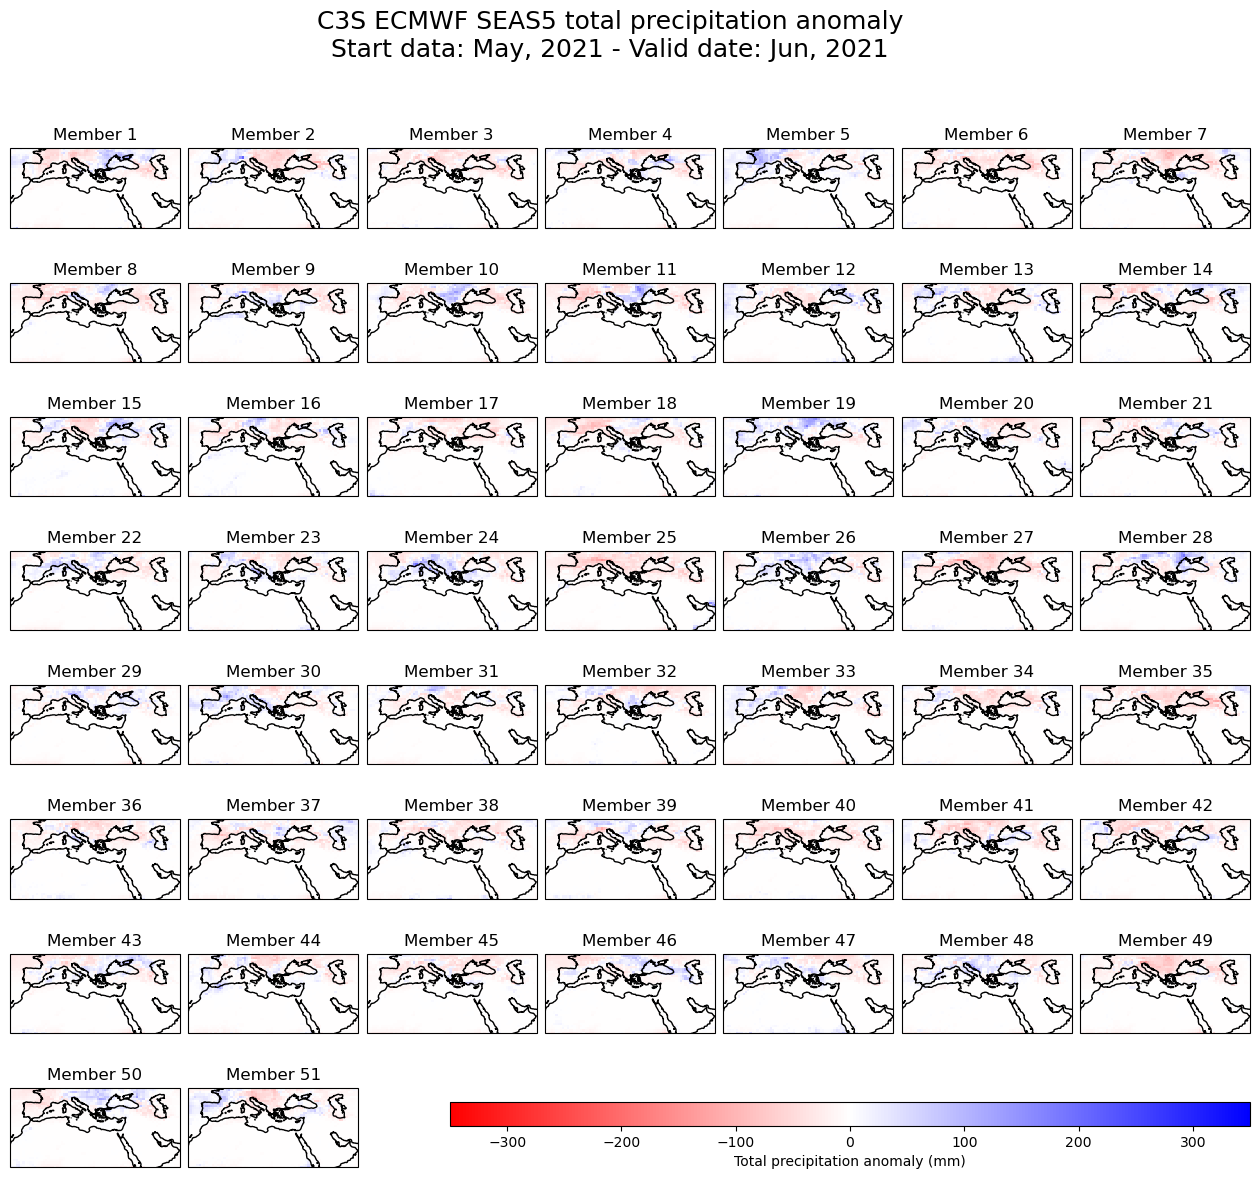

In [221]:
# Define figure and spacing between subplots
fig = plt.figure(figsize=(16, 12))
plt.subplots_adjust(hspace=0.15, wspace = 0.05)

new_date_format = seas5_MENA['valid_time'].dt.strftime('%b, %Y')

# Define overall title
plt.suptitle('C3S ECMWF SEAS5 total precipitation anomaly'
             + os.linesep + 
             f'Start data: {str(new_date_format[0].data)}' 
             + f' - Valid date: {str(new_date_format[lead_time-1].data)}'
             , fontsize=18)

# Define each subplot looping through the ensemble members
for n in np.arange(51):
    # Add a new subplot iteratively
    ax = plt.subplot(8, 7, n + 1, projection=ccrs.PlateCarree())
    # Plot data
    im = ax.pcolormesh(seas5_MENA.longitude.values, seas5_MENA.latitude.values, 
                       seas5_MENA[n,lead_time-1,:,:], cmap='bwr_r', vmin=-350, vmax=350)
    ax.set_title(f'Member {n+1}') # Set subplot title
    ax.coastlines(color='black') # Add coastlines
    # Set the extent (x0, x1, y0, y1) of the map in the given coordinate system.
    ax.set_extent([sub[1],sub[3],sub[2],sub[0]], crs=ccrs.PlateCarree())

# Create a colour bar at the bottom of the fugure
fig.subplots_adjust(bottom=0.0)
# Add axis to make space for colour bar (left, bottom, width, height)
cbar_ax = fig.add_axes([0.4, 0.05, 0.5, 0.02])
fig.colorbar(im, cax=cbar_ax, orientation='horizontal', label='Total precipitation anomaly (mm)')

# Save the figure
fig.savefig('{}/TotalPrecAnomalyForecastSAsia.png'.format(DATADIR) )

<br>

### 4.2 Plot of total precipitation anomalies for each seasonal forecast month

In this step we will summarise the total precipitation behaviour over the whole region for each lead time month. We will do this by averaging in the spatial (latitude and longitude) dimensions. 

To put the anomalies in context they will be compared to the reference climate computed in this subregion from the hindcast data.

#### Average over region

The first step is to create the weighted average of the subregion defined above. For this, we first estimate the cell area with the cosine of the latitude. These weights are then applied when the data array is averaged over the two dimensions `latitude` and `longitude`. You can use the xarray function `weighted()` together with the function `mean()` to create a weighted average of the geographical region. The result is a data array with two dimensions: `number` and `forecastMonth`.

In [223]:
weights =np.cos(np.deg2rad(seas5_MENA.latitude))

anoms_Smena = seas5_MENA.weighted(weights).mean(['latitude','longitude'])
anoms_Smena

<xarray.DataArray (number: 51, forecastMonth: 6)>
array([[ 1.24072130e+00, -1.97419906e+00, -1.57288175e+00,
        -3.61943914e-01,  6.35085306e-01,  1.52063362e+00],
       [-5.13339047e-01, -3.76850191e+00,  1.34013778e+00,
         6.79557215e+00, -9.83348491e-01, -4.69472276e+00],
       [-3.22093072e-01, -5.81791542e+00, -1.56837483e+00,
        -4.99987220e+00,  3.35193030e-01, -2.20208345e+00],
       [-1.11284617e-01, -2.48740713e+00, -2.27863660e-01,
        -2.84541735e+00, -4.70519464e-02, -3.26942271e+00],
       [-1.87099751e+00,  1.81536883e+00,  1.60744496e+00,
         9.63004084e-01, -3.00600110e+00, -3.43246119e-01],
       [-2.31581352e-01, -6.18320039e+00, -4.66969023e+00,
        -1.89885339e+00, -2.16303489e+00,  5.71617526e+00],
       [ 1.43797633e+00, -4.63679286e+00, -3.79867751e+00,
        -3.44432721e+00, -2.41703528e+00, -4.49213289e+00],
       [ 2.59359295e+00, -4.39424573e+00, -5.61078785e+00,
         1.14367510e+00,  2.15211883e+00, -5.43090971e+00],
       [ 7.52559478e-01, -3.15552390e+00, -1.05180870e+00,
        -4.11845078e+00, -2.75889852e+00,  4.38880821e+00],
       [-9.37020527e-01, -2.16483153e+00,  1.55760197e+00,
         1.30732197e+00,  2.14662433e+00, -8.54454243e+00],
...
       [-3.89259535e+00, -3.86904737e+00, -9.54907978e-01,
         4.55625722e-01,  1.22386636e+00, -1.58072657e+00],
       [-2.28969417e-01, -1.96659051e+00, -5.61953017e+00,
        -5.63373808e+00, -1.98454981e+00, -8.94884813e+00],
       [-8.87443080e-01, -2.56513558e+00, -3.41042090e+00,
        -2.81124231e+00, -4.82220073e+00, -6.00176284e+00],
       [-5.53723503e+00, -4.55547636e+00,  1.46574794e+00,
         7.25080896e+00, -6.52656061e-02,  3.11554941e-01],
       [-9.13198427e-01, -1.53894552e+00, -3.41657196e-01,
        -4.23263921e+00,  1.39433342e+00, -2.31341781e+00],
       [ 4.71340299e-02, -1.14592478e+00, -2.05924983e+00,
        -2.61079077e+00, -1.29203486e+00, -6.46055548e+00],
       [-1.14390404e+00,  1.77603795e-01, -2.23413564e+00,
         2.16698837e+00,  1.20563952e+00, -1.25219423e+01],
       [-2.95170279e+00, -6.87887472e+00, -3.23821375e+00,
        -5.50600294e+00,  2.06366715e+00, -9.10272758e+00],
       [-2.47601203e+00, -8.36384422e-01, -1.69611963e-01,
        -4.16373855e+00,  2.29541407e-02, -2.42992294e+00],
       [-6.50411868e-01, -1.87029796e+00, -1.12836345e+00,
        -6.14319574e+00, -3.26669299e+00, -1.92856527e+00]])
Coordinates:
  * number         (number) int64 0 1 2 3 4 5 6 7 8 ... 43 44 45 46 47 48 49 50
  * forecastMonth  (forecastMonth) int64 1 2 3 4 5 6
    time           datetime64[ns] 2021-05-01
    surface        float64 0.0
    valid_time     (forecastMonth) datetime64[ns] 2021-05-01 ... 2021-10-01
    numdays        (forecastMonth) int64 31 30 31 31 30 31

#### Conversion of data into two dimensional pivot table

To facilitate further processing we will convert the data array into a pandas.Dataframe object with the function `to_dataframe()`. Pandas dataframes are optimised for the processing and visualisation of two dimensional data. We may want to drop coordinates that are not needed. We can do this with the function `drop_vars()`.

In [225]:
anoms_Smena_df = anoms_Smena.drop_vars(['time','surface','numdays']).to_dataframe(name='anomaly')
anoms_Smena_df

valid_time   anomaly
number forecastMonth                     
0      1             2021-05-01  1.240721
       2             2021-06-01 -1.974199
       3             2021-07-01 -1.572882
       4             2021-08-01 -0.361944
       5             2021-09-01  0.635085
...                         ...       ...
50     2             2021-06-01 -1.870298
       3             2021-07-01 -1.128363
       4             2021-08-01 -6.143196
       5             2021-09-01 -3.266693
       6             2021-10-01 -1.928565

[306 rows x 2 columns]

We will now reorganise the data structure to facilitate plotting. We will do this through the use of the following Pandas functions:

> **reset_index().drop()**: We use `reset_index()` to convert the ensemble members into columns, and we use `drop()` to remove the *forecastMonth* column, as we have the same information in the *valid_time* dimension <br>
> **set_index()**: allows us to define which column(s) shall be used as data frame indices <br>
> **unstack()**: converts the columns into a pivot table, thus re-arranging the data into an easily manageable two dimensional table.<br>

In [227]:
anoms_Smena_df = anoms_Smena_df.reset_index().drop('forecastMonth',axis=1).set_index(['valid_time','number']).unstack()
anoms_Smena_df

anomaly                                                    \
number            0         1         2         3         4         5    
valid_time                                                               
2021-05-01  1.240721 -0.513339 -0.322093 -0.111285 -1.870998 -0.231581   
2021-06-01 -1.974199 -3.768502 -5.817915 -2.487407  1.815369 -6.183200   
2021-07-01 -1.572882  1.340138 -1.568375 -0.227864  1.607445 -4.669690   
2021-08-01 -0.361944  6.795572 -4.999872 -2.845417  0.963004 -1.898853   
2021-09-01  0.635085 -0.983348  0.335193 -0.047052 -3.006001 -2.163035   
2021-10-01  1.520634 -4.694723 -2.202083 -3.269423 -0.343246  5.716175   

                                                    ...                      \
number            6         7         8         9   ...        41        42   
valid_time                                          ...                       
2021-05-01  1.437976  2.593593  0.752559 -0.937021  ... -3.892595 -0.228969   
2021-06-01 -4.636793 -4.394246 -3.155524 -2.164832  ... -3.869047 -1.966591   
2021-07-01 -3.798678 -5.610788 -1.051809  1.557602  ... -0.954908 -5.619530   
2021-08-01 -3.444327  1.143675 -4.118451  1.307322  ...  0.455626 -5.633738   
2021-09-01 -2.417035  2.152119 -2.758899  2.146624  ...  1.223866 -1.984550   
2021-10-01 -4.492133 -5.430910  4.388808 -8.544542  ... -1.580727 -8.948848   

                                                                         \
number            43        44        45        46         47        48   
valid_time                                                                
2021-05-01 -0.887443 -5.537235 -0.913198  0.047134  -1.143904 -2.951703   
2021-06-01 -2.565136 -4.555476 -1.538946 -1.145925   0.177604 -6.878875   
2021-07-01 -3.410421  1.465748 -0.341657 -2.059250  -2.234136 -3.238214   
2021-08-01 -2.811242  7.250809 -4.232639 -2.610791   2.166988 -5.506003   
2021-09-01 -4.822201 -0.065266  1.394333 -1.292035   1.205640  2.063667   
2021-10-01 -6.001763  0.311555 -2.313418 -6.460555 -12.521942 -9.102728   

                                
number            49        50  
valid_time                      
2021-05-01 -2.476012 -0.650412  
2021-06-01 -0.836384 -1.870298  
2021-07-01 -0.169612 -1.128363  
2021-08-01 -4.163739 -6.143196  
2021-09-01  0.022954 -3.266693  
2021-10-01 -2.429923 -1.928565  

[6 rows x 51 columns]

The data frame above provides us for each ensemble member and forecast month the total precipitation anomaly.

As a last step, to improve the labels of our data plot later on, we will convert the `valid_time` column values from *YYYY-MM-DD* format into *Month, Year* format.

In [229]:
anoms_Smena_m_yr = anoms_Smena_df.reset_index()
anoms_Smena_m_yr['valid_time'] = anoms_Smena_m_yr['valid_time'].dt.strftime('%b, %Y')

#### Repeat steps for hindcast data (to compare forecast and hindcast anomalies)

We would like now to repeat the steps for the hindcast data in order to show the forecast in the context of the reference climate. I.e. we will compare the seasonal forecast and hindcast anomalies for each lead-time month. In the final plot we will show the anomaly of each forecast ensemble member, while the model climate defined by the hindcasts will be represented in the form of tercile categories. This will put each ensemble member forecast anomaly into context and will give us an indication of its intensity.

We therefore revisit the hindcast data (`tprate_hindcast`), which we loaded in [section 2](#hindcast_climate_mean) above. We will apply the same steps to create a geographical subset and aggregate spatially.

In [240]:
tprate_hindcast_Smena = ds_latlon_subset(tprate_hindcast, sub)

To create the weighted average of the two dimensions `latitude` and `longitude`, we can use the same `weights` as above.

In [242]:
tprate_hindcast_Smena = tprate_hindcast_Smena.weighted(weights).mean(['latitude','longitude'])

The resulting array has three remaining dimensions, `number`, `forecastMonth` and `time`.

The next step is to compute the hindcast anomalies using the hindcast climatology as reference. As before, we create the hindcast climatology by computing the mean over the two dimensions `number` (ensemble member) and `time` (years) resulting in the climatology for each lead-time month. We then subtract this from the hindcast data to derive the anomalies.

In [247]:
anom_hindcast = tprate_hindcast_Smena - tprate_hindcast_Smena.mean(['number','time'])

We now repeat the same steps to convert precipitation accumulations in m/s to total precipitation in m.

In [249]:
valid_time = [ pd.to_datetime(anom_hindcast.time.values[0]) + relativedelta(months=fcmonth-1) for fcmonth in anom_hindcast.forecastMonth]
numdays = [monthrange(dd.year,dd.month)[1] for dd in valid_time]
anom_hindcast = anom_hindcast.assign_coords(numdays=('forecastMonth',numdays))

In [251]:
anom_hindcast_tp = anom_hindcast * anom_hindcast.numdays * 24 * 60 * 60 * 1000

#### Calculation of hindcast anomaly terciles

Now, for each of the lead-time months, we can compute the minimum and maximum as well as the 1/3 and 2/3 percentiles of the hindcast anomaly ensemble.

In [254]:
P0 = anom_hindcast_tp.min(['number','time'])
P33 = anom_hindcast_tp.quantile(1/3.,['number','time'])
P66 = anom_hindcast_tp.quantile(2/3.,['number','time'])
P100 = anom_hindcast_tp.max(['number','time'])

A last step before we visualise this data is to 

The last step is to visualize the hindcast climatology boundaries as filled area and the ensemble seasonal forecast anomalies for each forecast month. The visualisation code below has three main sections:
> 1. **Initiate the figure**: Initiate a matplotlib figure <br>
> 2. **Plot the seasonal forecast anomalies + climatology boundaries**: Plot the ensemble seasonal forecast anomalies as black circles and the hindcast climatology as filled areas <br>
> 3. **Customise plot settings**: Add additonal features, such as title, x- and y-axis labels etc. <br>

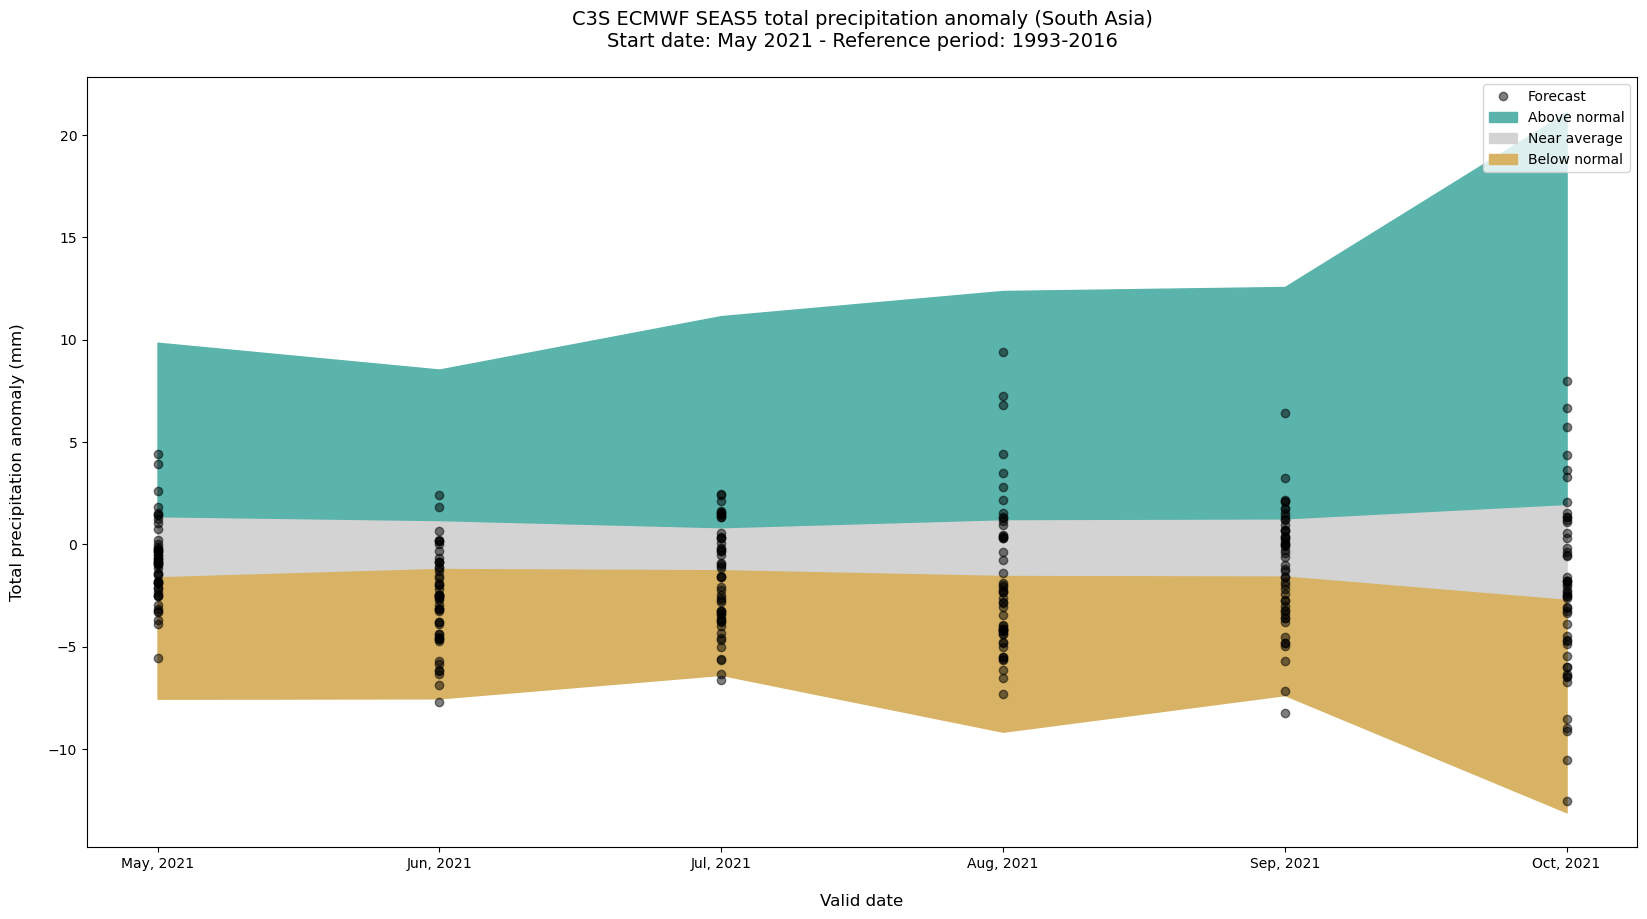

In [258]:
# Initiate the figure
fig=plt.figure(figsize=(20, 10))
ax=fig.gca()

# Plot the seasonal forecast anomalies + climatology boundaries as filled areas
ax.plot(anoms_Smena_m_yr.valid_time, anoms_Smena_m_yr.anomaly, marker='o', linestyle='', color='black', alpha=0.5, label='Forecast')
ax.fill_between(anoms_Smena_m_yr.index,P66,P100,color='#5ab4ac',label='Above normal')
ax.fill_between(anoms_Smena_m_yr.index,P33,P66,color='lightgray',label='Near average')
ax.fill_between(anoms_Smena_m_yr.index,P0,P33,color='#d8b365',label='Below normal')

# Customize plot settings
plt.title('C3S ECMWF SEAS5 total precipitation anomaly (South Asia)' 
          + os.linesep + 
          'Start date: May 2021 - Reference period: 1993-2016' 
          + os.linesep, fontsize=14)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

ax.set_ylabel('Total precipitation anomaly (mm)' + os.linesep, fontsize=12)
ax.set_xlabel(os.linesep + 'Valid date', fontsize=12)

# Save the figure
fig.savefig('{}/TotalPrecForecastHindcastAnomaliesSmena.png'.format(DATADIR) )

<br>

## 5. Calculate seasonal forecast 3-month anomalies

In this last section of the tutorial we will show how to create plots similar to those on the [Copernicus Climate Change Service (C3S) website](https://climate.copernicus.eu/charts/c3s_seasonal/). This process includes calculating 3-month aggregations and ensemble means. This differs from the previous sections where we have focussed on the processing of monthly data and individual members.

#### Compute 3-month rolling averages

The first step is to compute 3-month rolling averaged for the seasonal forecasts and hindcast data. We will do this through a combination of the xarray functions `rolling()` and `mean()`.

In [278]:
seas5_forecast_3m = seas5_forecast.rolling(forecastMonth=3).mean()
ds_hindcast_3m = ds_hindcast.rolling(forecastMonth=3).mean()

#### Calculate anomalies

We now repeat the process of calculating anomalies with respect to the climatology, this time for the 3-monthly data.

In [281]:
ds_hindcast_3m_hindcast_mean = ds_hindcast_3m.mean(['number','time'])
seas5_anomalies_3m_202105 = seas5_forecast_3m.tprate - ds_hindcast_3m_hindcast_mean.tprate

#### Ensemble mean anomaly

We want to compute the average of the 3-month seasonal forecast anomaly of the ensemble members. For this, we have to average over the dimension `number`. The final array has three dimensions, `forecastMonth`, `latitude` and `longitude`.

In [286]:
seas5_anomalies_3m_202105_em = seas5_anomalies_3m_202105.mean('number')

#### Convert precipitation rate to accumulation in mm

The last step before visualizing the 3-month seasonal forecast anomalies is again to convert the precipitation accumulations to total precipitation in mm. We repeat the same steps as previously:
> 1. **Calculate number of days for each forecast month and add it as coordinate info** <br>
> 2. **Name the 3-month rolling archives to indicate over which months the average was built** <br>
> 3. **Convert the precipitation accumulations based on the number of days** <br>
> 4. **Add updated attributes to the data array** <br>

In [290]:
vts

[[Timestamp('2021-05-01 00:00:00'),
  Timestamp('2021-04-01 00:00:00'),
  Timestamp('2021-03-01 00:00:00')],
 [Timestamp('2021-06-01 00:00:00'),
  Timestamp('2021-05-01 00:00:00'),
  Timestamp('2021-04-01 00:00:00')],
 [Timestamp('2021-07-01 00:00:00'),
  Timestamp('2021-06-01 00:00:00'),
  Timestamp('2021-05-01 00:00:00')],
 [Timestamp('2021-08-01 00:00:00'),
  Timestamp('2021-07-01 00:00:00'),
  Timestamp('2021-06-01 00:00:00')],
 [Timestamp('2021-09-01 00:00:00'),
  Timestamp('2021-08-01 00:00:00'),
  Timestamp('2021-07-01 00:00:00')],
 [Timestamp('2021-10-01 00:00:00'),
  Timestamp('2021-09-01 00:00:00'),
  Timestamp('2021-08-01 00:00:00')]]

In [269]:
# Calculate number of days for each forecast month and add it as coordinate information to the data array
vt = [ pd.to_datetime(seas5_anomalies_3m_202105_em.time.values) + relativedelta(months=fcmonth-1) for fcmonth in seas5_anomalies_3m_202105_em.forecastMonth]
vts = [[thisvt+relativedelta(months=-mm) for mm in range(3)] for thisvt in vt]
numdays = [np.sum([monthrange(dd.year,dd.month)[1] for dd in d3]) for d3 in vts]
seas5_anomalies_3m_202105_em = seas5_anomalies_3m_202105_em.assign_coords(numdays=('forecastMonth',numdays))

# Define names for the 3-month rolling archives, that give an indication over which months the average was built
vts_names = ['{}{}{} {}'.format(d3[2].strftime('%b')[0],d3[1].strftime('%b')[0],d3[0].strftime('%b')[0], d3[0].strftime('%Y'))  for d3 in vts]
seas5_anomalies_3m_202105_em = seas5_anomalies_3m_202105_em.assign_coords(valid_time=('forecastMonth',vts_names))
seas5_anomalies_3m_202105_em

# Convert the precipitation accumulations based on the number of days
seas5_anomalies_3m_202105_em_tp = seas5_anomalies_3m_202105_em * seas5_anomalies_3m_202105_em.numdays * 24 * 60 * 60 * 1000

# Add updated attributes
seas5_anomalies_3m_202105_em_tp.attrs['units'] = 'mm'
seas5_anomalies_3m_202105_em_tp.attrs['long_name'] = 'SEAS5 3-monthly total precipitation ensemble mean anomaly for 6 lead-time months, start date in May 2021.'

#### Visualise 3-monthly total precipitation ensemble mean anomalies

Let us now visualise the 3-month total precipitation ensemble mean anomaly in an interactive plot. Widgets (`ipywidgets`) allow us to add interactive features to Jupyter notebooks. We will use these to add a dropdown menu that offers the option to choose the 3-monthly periods over which the anomalies are averaged. Given that we have 6 lead-time months, we end up with only 4 possible 3-monthly periods (the last 2 months are insufficient to create a complete 3-month aggregation).

In [271]:
vts_names

['MAM 2021', 'AMJ 2021', 'MJJ 2021', 'JJA 2021', 'JAS 2021', 'ASO 2021']

In [273]:
dropdown_opts = [(vts_names[mm-1],mm) for mm in range(3,7)]

In [275]:
tp_colors = [(153/255.,51/255.,0),(204/255.,136/255.,0),(1,213/255.,0),
             (1,238/255.,153/255.),(1,1,1),(204/255.,1,102/255.),
             (42/255.,1,0),(0,153/255.,51/255.),(0,102/255.,102/255.)]  
tp_levels = [-200,-100,-50,-10,10,50,100,200]



def plot_leadt(ds, leadt_end):
    array = ds.sel(forecastMonth=leadt_end)
    fig, ax = plt.subplots(1, 1, figsize = (16, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    im = plt.contourf(array.longitude, array.latitude, array, 
                      levels=tp_levels, colors=tp_colors, extend='both')
    ax.set_title(f'{array.long_name}' + os.linesep + f'{array.valid_time.values}', fontsize=16)
    ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--') 
    ax.coastlines(color='black')
    cbar = plt.colorbar(im,fraction=0.05, pad=0.04)
    cbar.set_label(array.units)
    
    return
    
dropdown_opts = [(vts_names[mm-1],mm) for mm in range(3,7)] 
a=widgets.interact(plot_leadt, ds=widgets.fixed(seas5_anomalies_3m_202105_em_tp), 
                   leadt_end=widgets.Dropdown(options=dropdown_opts,description='Valid Time:', 
                                              style={'description_width': 'initial'}))


interactive(children=(Dropdown(description='Valid Time:', options=(('MJJ 2021', 3), ('JJA 2021', 4), ('JAS 202…

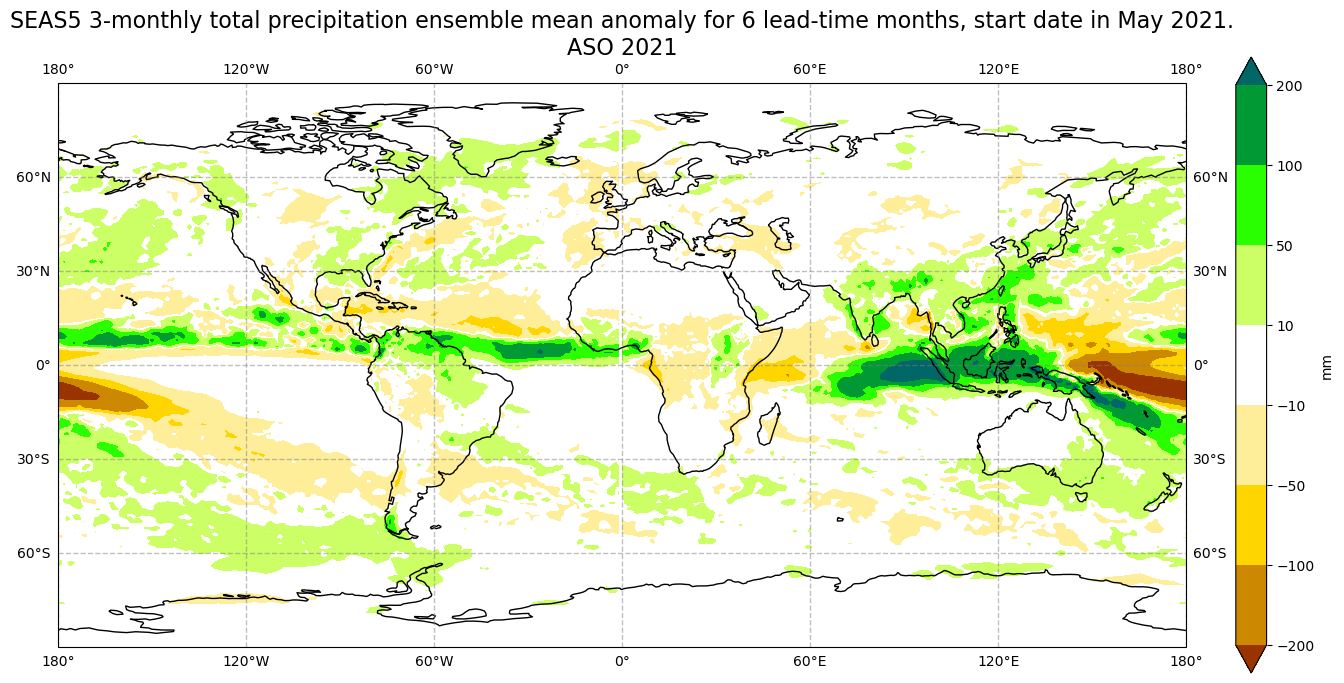

In [298]:
plot_leadt(seas5_anomalies_3m_202105_em_tp,6)

<div class="alert alert-block alert-success">
<b>NOTE</b>: <br>
    The plots shown here are similar but not identical to those on the <a href="https://climate.copernicus.eu/charts/c3s_seasonal/">Copernicus Climate Change Service (C3S) website</a>, specifically <a href="https://climate.copernicus.eu/charts/c3s_seasonal/c3s_seasonal_spatial_ecmf_rain_3m?facets=Parameters,precipitation%3BCentres,ECMWF&time=2021050100,744,2021060100&type=ensm&area=area08">here</a>. These plots are not identical however. The white areas in both plots, for example, have different meanings: those on the C3S website have a significance test to white-out non statistically-significant anomalies.</div>

<hr>

<p></p>
<span style='float:right'><p style=\"text-align:right;\">This project is licensed under <a href="./LICENSE">APACHE License 2.0</a>. | <a href=\"https://github.com/ecmwf-projects/copernicus-training">View on GitHub</a></span>